# Hog - Histogram of Oriented Gradients

L'obiettivo di questo Notebook è quello di estrarre le `hog features` dal dataset MNIST per poi costruire un modello di regressione logistica e valutarne l'accuratezza.

Inizialmente si importano le librerie necessarie: `sklearn`, `numpy`, `matplotlib` ed `skimage` da cui si importa `hog`.

In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from skimage.feature import hog
%matplotlib inline

Per prima cosa si carica il dataset `MNIST` e si assegna ad x la colonna del dataset contenente le immagini e ad y quella contenente le etichette.

In [2]:
mnist_data = fetch_openml('mnist_784')

In [3]:
x, y = mnist_data['data'], mnist_data['target']
y = y.astype(np.uint8)

print(f'x = {x.shape}    y = {y.shape}')

x = (70000, 784)    y = (70000,)


Una volta caricato il dataset si vogliono mostrare le prime N immagini con relative etichette.

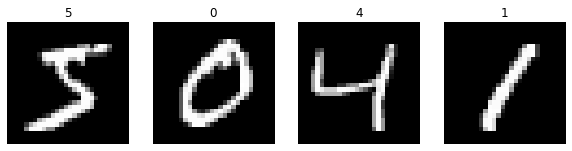

In [4]:
N=4
fig, ax = plt.subplots(1, N,figsize=(10,10))
for i in range(N):
    image = x[i].reshape(28,28)
    label = y[i] 
    ax[i].imshow(image, cmap='gray')
    ax[i].title.set_text(label)
    ax[i].axis('off')
plt.show()
    

Si estraggono le hog features dalle prime N immagini del dataset per visualizzarne la rappresentazione mediante le direzioni dei gradienti relativi ad ogni cella.

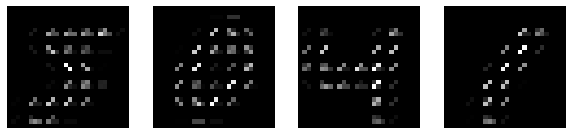

In [5]:
N=4
fig, ax = plt.subplots(1, N,figsize=(10,10))
for i in range(N):
    image = x[i].reshape(28,28)
    hog_features, hog_image = hog(image, orientations=9, pixels_per_cell=(4,4), feature_vector=False,
                    cells_per_block=(2,2), visualize=True, multichannel=False)
    ax[i].imshow(hog_image, cmap='gray')
    ax[i].axis('off')
plt.show()

# Estrazione delle features

A questo punto si può procedere con l'estrazione delle hog features dall'intero dataset.

Si è scelto di:
- Suddividere le immagini in celle di 4x4 pixel
- Utilizzare 9 bin per la creazione degli istogrammi
- Utilizzare blocchi di dimensione 2x2 celle
- Utilizzare L2 come metodo di normalizzazione dei blocchi.


In [6]:
x_hog_features = []
for img in x:
    img = img.reshape(28,28)
    fd, hog_img = hog(img, orientations=9, pixels_per_cell=(4,4), block_norm='L2', feature_vector= True,
                    cells_per_block=(2, 2), visualize=True, multichannel=False)
    x_hog_features.append(fd)

Impostando `feature_vector = True`, si ottiene un vettore monodimensionale di features per ogni immagine.

In [7]:
x_hog = np.array(x_hog_features)
x_hog.shape

(70000, 1296)

A questo punto il dataset è pronto per la fase di classificazione/regressione, ma nel caso in cui la dimensione del feature vector fosse troppo grande si può procedere ad una fase di decomposizione utilizzando la classe `PCA` della libreria `sklearn.decomposition`.

In questo modo ogni immagine avrà un feature vector di dimensione fissata, in questo caso 500.

In [8]:
from sklearn.decomposition import PCA
pca =PCA(n_components=500)
pca.fit(x_hog)
x_pca = pca.fit_transform(x_hog)
print(x_pca.shape)


(70000, 500)


# Regressione Logistica

Per prima cosa si procede allo split dei dataset, in particolare si utilizzano 2 dataset:
    - Il dataset ottenuto dall'estrazione delle hog_features
    - Il dataset iniziale di immagini
Si divide in Training set e Test set con il metodo `train_test_split`

In [37]:
from sklearn.model_selection import train_test_split

X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(x_pca, y, test_size=0.20, random_state=42)

Successivamente viene allenato il primo modello di regressione logistica.

In [38]:
from sklearn.linear_model import SGDClassifier

hogModel = SGDClassifier(loss='log', random_state=99)
hogModel.fit(X_train_hog, y_train_hog)
accuracy= hogModel.score(X_test_hog, y_test_hog)

Prima di procedere alla costruzione del secondo modello di regressione logistica per il dataset iniziale di immagini, normalizziamo i valori e successivamente procediamo con lo split in Train e Test set.

In [39]:
x_norm = []
for img in x:
    img = img/255.0
    x_norm.append(img)

X_train, X_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.20, random_state=42)

Alleniamo il secondo modello di regressione logistica e ne calcoliamo l'accuratezza sul Test set.

In [40]:
model2 = SGDClassifier(loss='log', random_state=99)
model2.fit(X_train, y_train)
accuracy2 = model2.score(X_test, y_test)

Infine visualizziamo i valori delle due accuratezze ottenute.

In [41]:
print(f'Accuracy modello 1 (hog): {accuracy}')
print(f'Accuracy modello 2: {accuracy2}')

Accuracy modello 1 (hog): 0.9782142857142857
Accuracy modello 2: 0.9152142857142858


Per confrontare al meglio i due modelli ottenuti visualizziamo le rispettive `confusion matrix`

In [42]:
from sklearn.metrics import confusion_matrix
import pandas as pd

y_pred_hog = hogModel.predict(X_test_hog)
cm = confusion_matrix(y_test_hog, y_pred_hog)

### Confusion Matrix Modello 1 (Hog)

In [43]:
pd.DataFrame(cm, columns=range(10)).head(10)

,0,1,2,3,4,5,6,7,8,9
0,1332,2,0,1,1,1,3,0,3,0
1,0,1587,4,2,0,0,1,5,1,0
2,3,6,1341,3,5,0,3,7,11,1
3,2,1,7,1398,0,5,0,9,6,5
4,3,1,1,0,1266,0,1,0,5,18
5,0,3,1,6,1,1252,2,1,7,0
6,4,0,0,0,5,4,1378,0,5,0
7,3,4,10,3,7,1,0,1467,2,6
8,5,3,13,4,3,5,5,6,1305,8
9,5,5,1,5,12,4,0,12,7,1369


### Confusion Matrix Modello 2

In [44]:
y_pred = model2.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm2, columns=range(10)).head(10)

,0,1,2,3,4,5,6,7,8,9
0,1310,2,5,0,1,7,7,3,8,0
1,0,1556,4,7,2,10,2,4,15,0
2,8,23,1244,13,23,9,12,18,26,4
3,8,11,43,1257,3,45,8,16,24,18
4,1,2,12,3,1215,2,5,6,13,36
5,9,13,10,48,19,1115,17,5,27,10
6,3,4,21,0,17,23,1320,1,7,0
7,8,5,24,1,17,5,0,1405,1,37
8,17,33,17,40,12,38,10,11,1147,32
9,10,10,8,22,63,8,0,47,8,1244
